In [868]:
import math as math
import autograd as Agrad
import autograd.numpy as np 
import autograd.numpy.fft as fft
#import numpy as np
#import numpy.fft as fft
import scipy.optimize
import scipy.stats as st
import scipy.signal as sg
from scipy.integrate import trapz
from scipy.integrate import simps
from photutils import find_peaks
from photutils import detect_threshold
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
mpl.rcParams.update({'font.size': 22})

np.random.seed(42)

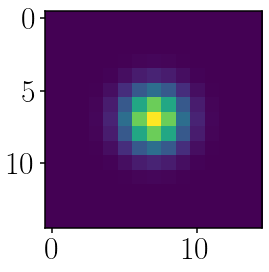

In [869]:
#create global definitions for the data

#create global definitions - this will become a main function later on
np.random.seed(42)
Ndata = 5;
n_grid = 15;
pix_1d = np.linspace(0., 1., n_grid) # pixel gridding
fdensity_true = float(Ndata)/float(n_grid**2); #number density of obj in 1d
#epsilon = 1.355;
epsilon = 4.1;

#use very small psf and noise
sig_psf = 0.1 # psf width
#sig_noise = 0.01 # noise level
sig_noise = 0.1 # noise level

#create our psf
mid = int(n_grid/2);
x,y = np.meshgrid(pix_1d,pix_1d);
psf = np.exp(-((y-pix_1d[mid])**2 + (x - pix_1d[mid])**2)/2/sig_psf**2); #keep in mind difference between x and y position and indices! Here, you are given indices, but meshgrid is in x-y coords
#fourier transform of psf
psf_k = fft.fft2(psf);
#display psf
plt.imshow(psf);

In [870]:
#create the mock data we will work on
#create coordinate grid
theta_grid = np.linspace(0., 1., n_grid) # gridding of theta (same as pixels)

#create true values - assign to grid
x_true = np.abs(np.random.rand(Ndata)) # location of sources
y_true = np.abs(np.random.rand(Ndata));
#w_true = np.abs(np.random.rand(Ndata))*2 # with intensity betwen 1-2
#sample from power law
w_lin = np.linspace(0.1,2,100);#range of intensities
alpha_true = 2;
w_norm = (w_lin[-1]**(alpha_true+1) - w_lin[0]**(alpha_true+1))/(alpha_true+1); #normalization from integrating
w_func = np.power(w_lin,alpha_true)/w_norm; #pdf to sample intensities, also p1
w_true = w_norm*np.random.choice(w_func,Ndata)
print(w_true);
#true grid needs to be set up with noise
w_true_grid = np.zeros((n_grid,n_grid))
for x,y, w in zip(x_true,y_true, w_true): 
    w_true_grid[np.argmin(np.abs(theta_grid - x)),np.argmin(np.abs(theta_grid - y))] = w
#now create the 'data' by convolving with psf and adding random noise
#by convolution thrm we convolve by inverse tranforming the multiplication of the fft of the data and fft of the psf
noise_grid = np.absolute(sig_noise* np.random.randn(n_grid,n_grid));
data = np.real(fft.ifft2(fft.fft2(w_true_grid)*psf_k)) + noise_grid; #circular conv to work with
data_toshow = sg.convolve(w_true_grid,psf,mode='same') + noise_grid; #linear conv variant for plotting

[0.25303949 1.20555964 0.01420671 3.13182736 0.43107846]


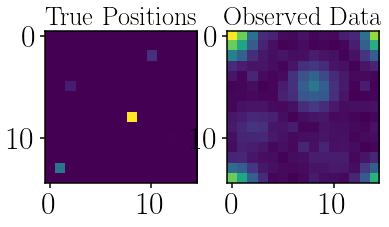

In [871]:
#display the true coordinates and observed data
fig, ax = plt.subplots(1,2)
ax[0].imshow(w_true_grid);
ax[0].set_title('True Positions')
ax[1].imshow(data);
ax[1].set_title('Observed Data')
plt.show();

Notice that the positions of the observed data do not match the true positions. This is due to the periodic boundary conditions of doing convolution, as we do not use padding to adjust.

In [872]:
#In order to minmize w.r.t. complex numbers we embed the complex nummbers into real space with twice the dimensions
#e.g. C -> 2R
#here are our helper functions for this
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.real(np.concatenate((np.real(z), np.imag(z))));

#our prior is a lognormal so we make helper functions
norm_mean = -5.; #mean for lognormal
norm_sig = 0.75;

#expects ws, NOT the fourier coefficients ws_k
def lognorm(ws):
    return np.exp(-0.5*(np.log(ws) - norm_mean)**2 /norm_sig**2)/np.sqrt(2*np.pi)/norm_sig/ws;

#derivative of lognorm
def diff_lognorm(ws):
    #taken from: https://iopscience.iop.org/article/10.1088/1742-6596/1338/1/012036/pdf
    df = -1*lognorm(ws)*(1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2);
    
    return df;

In [873]:
#now we define our loss function (basically log likelihood)
#ws is the fourier coefficients embedded into the reals and flattened to a 1d array

def loss_like(ws_k):
    #gaussian likelihood, assumes ws_k is in complex form and 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    like_loss = 0.5 * np.sum((conv - data)**2) /sig_noise**2 #gaussian likelihood loss
    
    return like_loss;
def loss_prior(ws):
    #prior, assumes ws_k is in complex form and 2d
    #ws = np.real(fft.ifft2(ws_k)); #need ws to calc prior (maybe I'll figure out a way to only use ws_k later)
    p1 = ws**alpha_true /w_norm;
    p2 = 0;
    prior = lognorm(ws)*(1-fdensity_true-fdensity_true**2) + fdensity_true*p1 + p2*fdensity_true**2; #full prior
    lnprior = np.log(prior); #remember we work in logspace for this
    prior_loss = np.sum(lnprior);
    
    return prior_loss;

def loss_fn_real(wsp_k):
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    return loss_like(ws_k)-loss_prior(ws);

def loss_fn(wsp_k):
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    return loss_like(ws_k) - loss_prior(ws);

In [874]:
#analytical gradient or likelihood
def grad_like(wsp,ws,ws_k):
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    term1 = (conv - data)/n_grid**2 /sig_noise**2 #term thats squared in like (with N in denom)
    grad = np.zeros((n_grid,n_grid),dtype='complex')
    for i in range(0,n_grid):
        for j in range(0,n_grid):        
            #try to modulate by hand
            ft1 = fft.fft2(1/(1+np.exp(-1*wsp/epsilon)));
            ftp = np.roll(ft1,(i,j),axis=(0,1));
            term2 = fft.ifft2(ftp*psf_k);
            grad[i,j] = np.sum(term1*term2);
    grad_real = complex_to_real(np.conj(grad.flatten())); #embed to 2R
    return grad_real; #return 1d array

#analytical gradient of prior
def grad_prior(wsp,ws,ws_k):
    
    param_term = 1/(1+np.exp(-1*wsp/epsilon)) #differentiation term due to parametrization
    #grad = fft.ifft2((-1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2)*param_term); #version with p1=0
    numerator = (1+(np.log(ws)-norm_mean)/norm_sig**2)*lognorm(ws)/ws + fdensity_true*alpha_true*ws**(alpha_true-1)/w_norm;
    prior = lognorm(ws)*(1-fdensity_true-fdensity_true**2) + fdensity_true*ws**(alpha_true)/w_norm; #prior w/o log
    grad = fft.ifft2(param_term*numerator/prior);
    grad_real = complex_to_real(np.conj(grad.flatten())); #embed to 2R
    return grad_real; #return 1d array

def grad_loss(wsp_k):
    wsp_k = real_to_complex(wsp_k); #2*reals -> complex
    wsp_k = wsp_k.reshape((n_grid,n_grid)); #reshape to 2d
    wsp = np.real(fft.ifft2(wsp_k));
    ws = epsilon*np.log(np.exp(wsp/epsilon)+1) #reparametrize from m_prime back to m
    ws_k = fft.fft2(ws);
    
    return grad_like(wsp,ws,ws_k)-grad_prior(wsp,ws,ws_k);

In [875]:
#now we optimize wrt ws_k, the fourier coefficients

#create initial parameters
tt0 = np.zeros((n_grid,n_grid)) + 10; #begin with high uniform mass in each pixel
tt0 = epsilon*np.log(np.exp(tt0/epsilon)-1);
tt0_k = fft.fft2(tt0); #take fft
t_ini = complex_to_real(tt0_k.flatten()) #flatten to 1d for scipy and embed in 2R

In [876]:
#define autograd gradients
def afunc(th):
    gfunc = Agrad.grad(lambda tt: loss_fn(tt));
    gr = gfunc(th);
    gr[len(gr)//2:] = -1*gr[len(gr)//2:];
    return gr;
def areal(th):
    th_comp = real_to_complex(th);
    gfunc = Agrad.holomorphic_grad(lambda tt: loss_fn_real(tt));
    grad_comp = gfunc(th_comp);
    grad_real = complex_to_real(np.conj(grad_comp));
    return grad_real;

def hfunc(th):
    gfunc = Agrad.hessian(lambda tt: loss_fn(tt));
    gr = gfunc(th);
    #gr[len(gr)//2:,:] = -1*gr[len(gr)//2:,:]
    hess = np.zeros((2*n_grid**2,2*n_grid**2)); #factor of two because of embeding from C -> 2R
    di = [ gr[i][i] for i in range(len(gr)) ]
    #print(di);
    di[len(di)//2:] = -1*di[len(di)//2:];
    np.fill_diagonal(hess,di);
    return hess;    

In [877]:
#test analytical gradient
#test gradient
aval = areal(t_ini);
gval = grad_loss(t_ini);
print(aval-gval);
print('gval');
print(gval)
print('aval');
print(aval);


[ 5.82076609e-11 -4.27746727e-12 -4.61852778e-12 -2.93720603e-12
 -5.01698683e-12  2.49825161e-12 -8.84006692e-12  2.14934125e-12
  2.14934125e-12 -8.84006692e-12  2.49825161e-12 -5.01698683e-12
 -2.93720603e-12 -4.61852778e-12 -4.27746727e-12 -6.89226454e-12
  1.84741111e-13 -9.52127266e-13 -2.99316127e-13  5.05262499e-13
  6.97046587e-13 -3.41443887e-13 -2.02188667e-12 -6.88858692e-15
 -4.05552328e-13 -6.57777652e-13 -2.73003842e-13  5.33795230e-13
 -1.33582034e-12  2.28794761e-12  4.68958206e-13  9.84101689e-13
  2.20623519e-12 -9.82103288e-13  5.81201753e-14  2.56222127e-12
 -6.47894932e-13  5.26683406e-13  1.51302411e-12 -6.85079814e-13
  1.76447051e-12 -1.14036558e-12 -6.39488462e-14  3.65929509e-13
 -1.70530257e-13 -2.39452902e-12  5.30242517e-13 -8.42437231e-13
 -2.43416398e-13  8.17922119e-14 -1.75454096e-12 -1.65453404e-12
 -7.85004752e-13 -1.25229686e-12 -7.64700694e-13 -2.72437628e-12
  5.25177124e-13 -4.98656672e-13 -7.43849426e-13 -8.03801470e-13
 -6.86037338e-12 -6.69020

In [878]:
#test loss is working
w_pert = w_true_grid + .000001;
wprime = epsilon*np.log(np.exp(w_pert/epsilon)-1);
wprime_k = fft.fft2(wprime); #take fft
wprime_k = complex_to_real(wprime_k.flatten()) #flatten to 1d for scipy and embed in 2R
#print(wprime_k);
print(loss_fn(wprime_k));

7255.7437753447375


In [879]:

#optimize using scipy and our analytic gradients
res = scipy.optimize.minimize(lambda tt: loss_fn(tt),
    t_ini, # theta initial
    jac=areal,                          
    method='BFGS');
print('Number of Iterations');
print(res['nit']);
print('Final Loss');
print(loss_fn(res['x']));
#remember this returns the fourier coefficients embeded in the reals
w_final_k = real_to_complex(res['x']);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
w_final = epsilon*np.log(np.exp(w_final/epsilon)+1);
#print(w_final);
w_final[w_final == np.inf] = 0;
#w_final[w_final < .]

Number of Iterations
403
Final Loss
-946.1261767034655


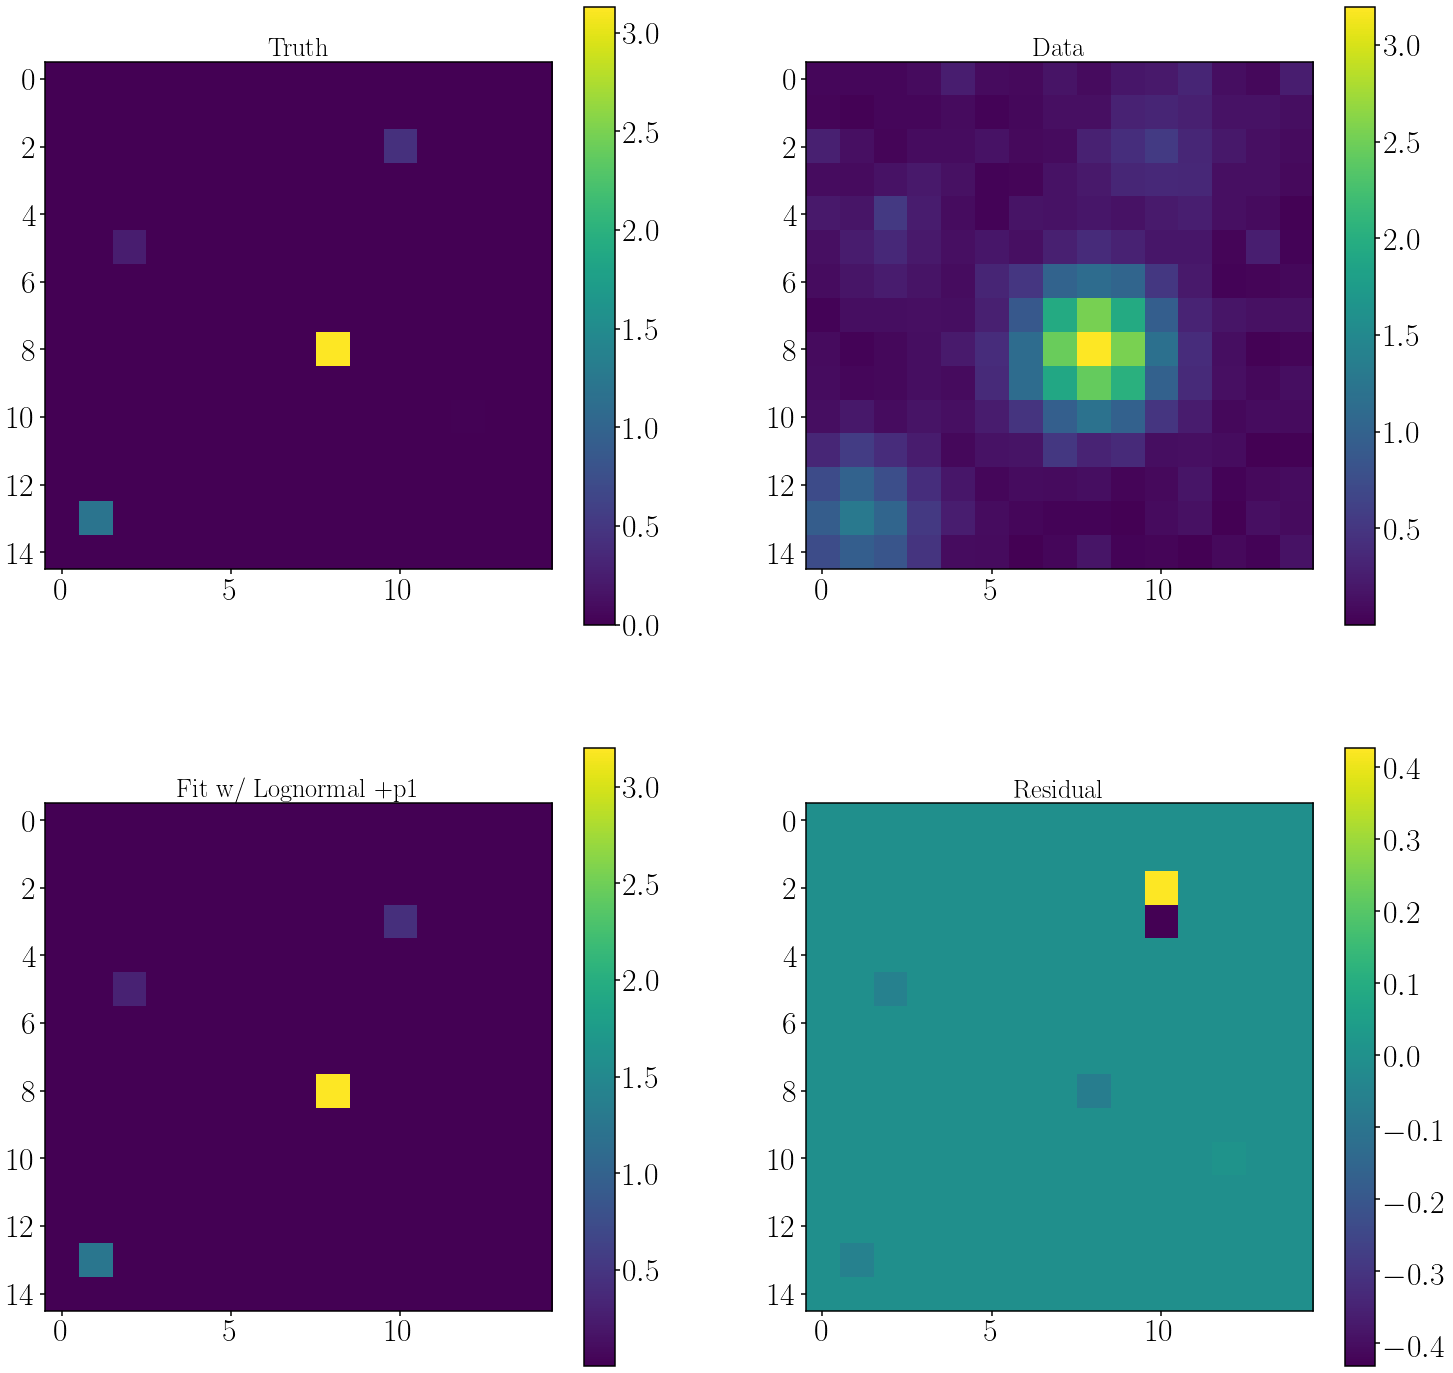

In [880]:
fig, ax = plt.subplots(2,2,figsize=(25,25));
pl0 = ax[0][0].imshow(w_true_grid);
ax[0][0].set_title('Truth')
pl1 = ax[0][1].imshow(data_toshow);
ax[0][1].set_title('Data')
pl2 = ax[1][0].imshow(w_final);
ax[1][0].set_title('Fit w/ Lognormal +p1')
pl3 = ax[1][1].imshow(w_true_grid-w_final);
ax[1][1].set_title('Residual');
fig.colorbar(pl0, ax=ax[0][0])
fig.colorbar(pl1, ax=ax[0][1])
fig.colorbar(pl2, ax=ax[1][0])
fig.colorbar(pl3, ax=ax[1][1])